In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import random
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import os
import shutil
import string
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

use_cuda = False

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.mount("/content/gdrive", force_remount=True)
# drive.flush_and_unmount()

Mounted at /content/gdrive


# Path

In [ ]:
# Shuyan
# drive_path = '/content/gdrive/My Drive/Documents/University Documents/Fourth Year/APS360/APS360 Project/'
# Shihang
# drive_path = '/content/gdrive/My Drive/APS360/APS360 Project/'
# Evelyn
drive_path = '/content/gdrive/My Drive/APS360H1 S/APS360 Project/'
# Zian
# drive_path = '/content/gdrive/My Drive/APS360H1 S/APS360 Project/'

In [ ]:
# archived_dataset_path = os.path.join(drive_path, "GTSRB_dataset", "archive")
dataset_path = os.path.join(drive_path, "GTSRB_dataset", "new")
# archived_feature_path = os.path.join(drive_path, "Archived_ResNet_features")
feature_path = os.path.join(drive_path, "ResNet_features")

## /content

In [ ]:
import os
workdir = os.getcwd()

## Load Embeddings into /content

In [ ]:
# !cp -rv "$archived_feature_path" "$workdir"
!cp -rv "$feature_path" "$workdir"

Streaming output truncated to the last 5000 lines.
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1257.tensor' -> '/content/ResNet_features/new_val/25/1257.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1292.tensor' -> '/content/ResNet_features/new_val/25/1292.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1294.tensor' -> '/content/ResNet_features/new_val/25/1294.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1335.tensor' -> '/content/ResNet_features/new_val/25/1335.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1344.tensor' -> '/content/ResNet_features/new_val/25/1344.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/1409.tensor' -> '/content/ResNet_features/new_val/25/1409.tensor'
'/content/gdrive/My Drive/APS360H1 S/APS360 Project/ResNet_features/new_val/25/

In [ ]:
# train_path = os.path.join(workdir, "Archived_ResNet_features", "train")
# valid_path = os.path.join(workdir, "Archived_ResNet_features", "valid")
# test_path = os.path.join(workdir, "Archived_ResNet_features", "test")

new_train_path = os.path.join(workdir, "ResNet_features", "new_train")
new_valid_path = os.path.join(workdir, "ResNet_features", "new_val")
new_test_path = os.path.join(workdir, "ResNet_features", "new_test")

our_test_path = os.path.join(workdir, "ResNet_features", "our_test")

# Classifier

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc1 = nn.Linear(2048, 1500)
        self.fc2 = nn.Linear(1500, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = F.relu(self.fc1(flattened))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class CNN_PReLU(nn.Module):
    def __init__(self):
        super(CNN_PReLU, self).__init__()
        self.name = "CNN_PReLU" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.PReLU(),
            nn.Linear(1024, 256),
            nn.PReLU(),
            nn.Linear(256, 43)
        )

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class CNN_simpler(nn.Module):
    def __init__(self):
        super(CNN_simpler, self).__init__()
        self.name = "CNN_simpler" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 43)
        )

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class CNN_simplest(nn.Module):
    def __init__(self):
        super(CNN_simplest, self).__init__()
        self.name = "CNN_simplest" # Can be used to indicate which hyperparameter set
        #input dimension would be 1*2048
        self.fc = nn.Linear(2048, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class CNN_dropout(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(CNN_dropout, self).__init__()
        self.name = "CNN_dropout"
        # input dimension would be 1*2048
        self.fc1 = nn.Linear(2048, 1500)
        self.dropout1 = nn.Dropout(dropout_p)  # Dropout layer after fc1
        self.fc2 = nn.Linear(1500, 1000)
        self.dropout2 = nn.Dropout(dropout_p)  # Dropout layer after fc2
        self.fc3 = nn.Linear(1000, 500)
        self.dropout3 = nn.Dropout(dropout_p)  # Dropout layer after fc3
        self.fc4 = nn.Linear(500, 100)
        self.dropout4 = nn.Dropout(dropout_p)  # Dropout layer after fc4
        self.fc5 = nn.Linear(100, 43)

    def forward(self, x):
        flattened = x.view(-1, 2048)
        x = F.relu(self.fc1(flattened))
        x = self.dropout1(x)  # Apply dropout after activation
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after activation
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)  # Apply dropout after activation
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)  # Apply dropout after activation
        x = self.fc5(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

# Training and Plotting

In [ ]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         acc: A scalar for the avg classification accuracy over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_acc = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage - put imgs and labels (data) under GPU memory, cuda is NVidia GPU framework
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        corr = pred.eq(labels.view_as(pred))
        total_acc += corr.sum().item()
        total_loss += loss.item()
        total_epoch += inputs.shape[0]
    acc = float(total_acc) / total_epoch
    loss = float(total_loss) / (i + 1)
    return acc, loss

def get_model_name(batch_size, learning_rate, epoch, name="CNN", drive_path=drive_path):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "{0}/Primary_checkpoint/model_{1}_bs{2}_lr{3}_epoch{4}".format(drive_path,
                                                                          name,
                                                                          batch_size,
                                                                          learning_rate,
                                                                          epoch)
    return path


In [ ]:
def train(model, dataset_train, dataset_val, batch_size=32, num_epochs=10, learning_rate = 0.01):

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # train_data = train_RestNet_loader
    # val_data = val_RestNet_loader
    print("Data loaded, start training. ")
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        i = 0
        for features, labels in iter(dataloader_train):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
              # print("GPU enabled")
            # #############################################
            out = model(features)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Evaluate
            total_train_loss += loss.item()
            pred = out.max(1, keepdim=True)[1]
            total_train_acc += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += features.shape[0]
            i += 1

        # save the current training information
        train_acc[epoch] = float(total_train_acc) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(model, dataloader_val, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(batch_size, learning_rate, epoch, name=model.name)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # print best results
    print("-------------------------")
    max_train_acc_idx = np.argmax(train_acc)
    min_train_loss_idx = np.argmin(train_loss)
    print("Best TRAIN results:")
    print(f"Epoch {max_train_acc_idx+1}: Highest train acc: {train_acc[max_train_acc_idx]},")
    print(f"Epoch {min_train_loss_idx+1}: Lowest train loss: {train_loss[min_train_loss_idx]}")

    max_val_acc_idx = np.argmax(val_acc)
    min_val_loss_idx = np.argmin(val_loss)
    print("Best VALIDATION results:")
    print(f"Epoch {max_val_acc_idx+1}: Highest val acc: {val_acc[max_val_acc_idx]},")
    print(f"Epoch {min_val_loss_idx+1}: Lowest val loss: {val_loss[min_val_loss_idx]}")

    # Write the train/val loss/acc into CSV file for plotting later
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Hyperparameter Tuning

## *Model 10

In [ ]:
model10 = CNN_simpler()
model10.name = 'model10_new'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model10, train_RestNet_dataset, val_RestNet_dataset, batch_size=512, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.29701356598437273, Train loss: 2.303877909978231 |Validation acc: 0.4766939687267312, Validation loss: 1.5936289855412074
Epoch 2: Train acc: 0.5631081923205983, Train loss: 1.2735932242302668 |Validation acc: 0.601042442293373, Validation loss: 1.172930760043008
Epoch 3: Train acc: 0.6713963855999233, Train loss: 0.9370633718513307 |Validation acc: 0.7011169024571854, Validation loss: 0.8839053767068046
Epoch 4: Train acc: 0.7405205886582619, Train loss: 0.7393816397303626 |Validation acc: 0.7207743857036486, Validation loss: 0.827744368995939
Epoch 5: Train acc: 0.7862518575331959, Train loss: 0.6188937141781762 |Validation acc: 0.7559195830230826, Validation loss: 0.7230151423386165
Epoch 6: Train acc: 0.8211015771056037, Train loss: 0.5141558512335732 |Validation acc: 0.7976172747580045, Validation loss: 0.6053701426301684
Epoch 7: Train acc: 0.8478021187862519, Train loss: 0.44085370004177094 |Validation acc: 0.7965748324646315, 

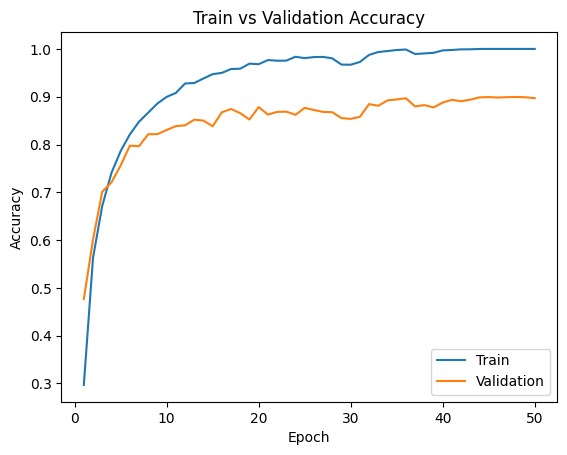

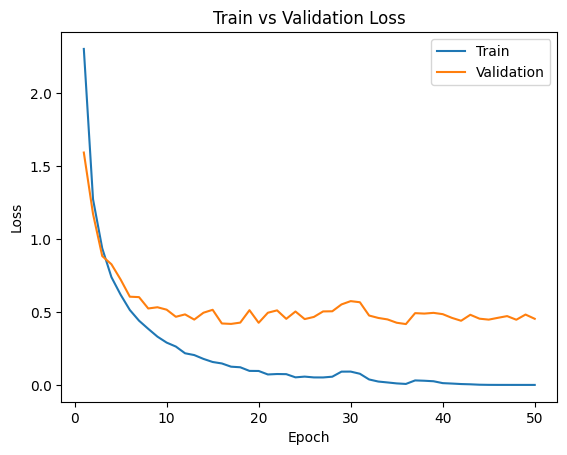

In [ ]:
path10 = get_model_name(name=model10.name,
                        batch_size=512,
                        learning_rate=0.003,
                        epoch=49)

plot_training_curve(path10)

## Model 11

In [ ]:
model11 = CNN_simplest()
model11.name = 'model11'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))

train(model11, train_RestNet_dataset, val_RestNet_dataset, batch_size=512, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.28258602711157454, Train loss: 2.563019461101956 |Validation acc: 0.4544833242208857, Validation loss: 1.9255696455637614
Epoch 2: Train acc: 0.5509210983663538, Train loss: 1.535794781314002 |Validation acc: 0.5650628758884636, Validation loss: 1.5094601313273113
Epoch 3: Train acc: 0.6503302050747306, Train loss: 1.2071998980310228 |Validation acc: 0.6421541826134499, Validation loss: 1.2701799790064494
Epoch 4: Train acc: 0.7152126057235546, Train loss: 1.026207360956404 |Validation acc: 0.6798797156916347, Validation loss: 1.1346925656000773
Epoch 5: Train acc: 0.7468427760398564, Train loss: 0.91042650408215 |Validation acc: 0.7039365773646802, Validation loss: 1.055361239115397
Epoch 6: Train acc: 0.7762715791912872, Train loss: 0.8140482538276248 |Validation acc: 0.7253963914707491, Validation loss: 0.975274403889974
Epoch 7: Train acc: 0.7995597265670258, Train loss: 0.7440949413511488 |Validation acc: 0.7364680153089119, Vali

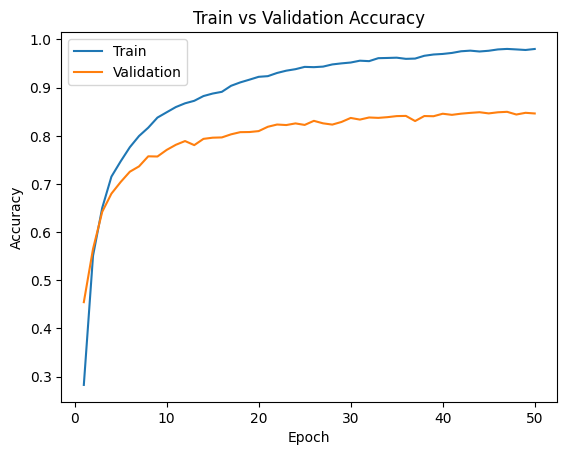

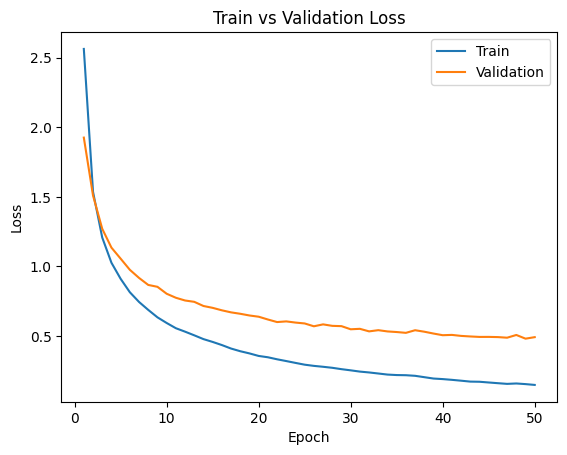

In [ ]:
path11 = get_model_name(name="model11",
                            batch_size=512,
                            learning_rate=0.003,
                            epoch=49)

plot_training_curve(path11)

## Model 12

In [ ]:
model12 = CNN_simpler()
model12.name = 'model12'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model12, train_RestNet_dataset, val_RestNet_dataset, batch_size=512, num_epochs=50, learning_rate = 0.001)

Data loaded, start training. 
Epoch 1: Train acc: 0.32889123244331525, Train loss: 2.278567623524439 |Validation acc: 0.48175725986597173, Validation loss: 1.6258826085499354
Epoch 2: Train acc: 0.5645462825367912, Train loss: 1.32941282363165 |Validation acc: 0.6065524944154878, Validation loss: 1.2046265772410802
Epoch 3: Train acc: 0.6597478548487609, Train loss: 1.014954761380241 |Validation acc: 0.6947133283693224, Validation loss: 0.9730425434453147
Epoch 4: Train acc: 0.7179425722640334, Train loss: 0.8383327765124184 |Validation acc: 0.725837676842889, Validation loss: 0.8307193475110191
Epoch 5: Train acc: 0.7595513158525479, Train loss: 0.7188241595313662 |Validation acc: 0.7411764705882353, Validation loss: 0.8106191371168409
Epoch 6: Train acc: 0.7862039211926561, Train loss: 0.6372641140506381 |Validation acc: 0.7566641846612062, Validation loss: 0.7449652297156197
Epoch 7: Train acc: 0.814150807727338, Train loss: 0.5544923770995367 |Validation acc: 0.7818317200297841, Va

## Model 13

In [ ]:
model13 = CNN_PReLU()
model13.name = 'model13'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model13, train_RestNet_dataset, val_RestNet_dataset, batch_size=512, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.35228416662671974, Train loss: 2.1112283837227594 |Validation acc: 0.5408786299329859, Validation loss: 1.352641156741551
Epoch 2: Train acc: 0.6299314510330282, Train loss: 1.050750875756854 |Validation acc: 0.6932241250930752, Validation loss: 0.91160848736763
Epoch 3: Train acc: 0.743732323474426, Train loss: 0.730461767741612 |Validation acc: 0.7279225614296352, Validation loss: 0.8072790631226131
Epoch 4: Train acc: 0.7889842289439625, Train loss: 0.5929681942576454 |Validation acc: 0.7611317944899478, Validation loss: 0.7081934937408992
Epoch 5: Train acc: 0.8420976942620201, Train loss: 0.45195927364485605 |Validation acc: 0.8001489203276247, Validation loss: 0.6003007505621228
Epoch 6: Train acc: 0.8607928670725277, Train loss: 0.3903500572556541 |Validation acc: 0.8105733432613552, Validation loss: 0.5724025517702103
Epoch 7: Train acc: 0.8814054935046258, Train loss: 0.3365213459446317 |Validation acc: 0.8227848101265823, Va

## Model 14

In [ ]:
model14 = CNN_simpler()
model14.name = 'model14'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model14, train_RestNet_dataset, val_RestNet_dataset, batch_size=256, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.375101864723647, Train loss: 2.006740348884858 |Validation acc: 0.5699180938198064, Validation loss: 1.2995497827176694
Epoch 2: Train acc: 0.6363549206653564, Train loss: 1.050813211015908 |Validation acc: 0.6985852568875651, Validation loss: 0.9190324500755027
Epoch 3: Train acc: 0.7333301375772974, Train loss: 0.7628014288752912 |Validation acc: 0.705584512285927, Validation loss: 0.8535812497138977
Epoch 4: Train acc: 0.7791093427927712, Train loss: 0.6233107645109476 |Validation acc: 0.7661950856291884, Validation loss: 0.6973667807049222
Epoch 5: Train acc: 0.8230190307271943, Train loss: 0.5096711706684296 |Validation acc: 0.7739389426656739, Validation loss: 0.6604563505561264
Epoch 6: Train acc: 0.855663678634773, Train loss: 0.4139813784375248 |Validation acc: 0.8059568131049888, Validation loss: 0.5899686846468184
Epoch 7: Train acc: 0.8837064378505345, Train loss: 0.33567596612924555 |Validation acc: 0.80536113179449, Vali

## Model 15

In [ ]:
model15 = CNN_simpler()
model15.name = 'model15'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model15, train_RestNet_dataset, val_RestNet_dataset, batch_size=1024, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.22137002061262642, Train loss: 2.647526963190599 |Validation acc: 0.37155621742367834, Validation loss: 1.9252288511821203
Epoch 2: Train acc: 0.45855903360337474, Train loss: 1.5741646560755642 |Validation acc: 0.5125837676842889, Validation loss: 1.4552427870886666
Epoch 3: Train acc: 0.5934998322228081, Train loss: 1.1599294597452336 |Validation acc: 0.6159344750558451, Validation loss: 1.1521480253764562
Epoch 4: Train acc: 0.6721633670485595, Train loss: 0.9263506450436332 |Validation acc: 0.6635889798957558, Validation loss: 0.9980153867176601
Epoch 5: Train acc: 0.7223047792531518, Train loss: 0.7893298187039115 |Validation acc: 0.7125837676842889, Validation loss: 0.8593965428216117
Epoch 6: Train acc: 0.7691865203010402, Train loss: 0.662811739878221 |Validation acc: 0.7410275502606106, Validation loss: 0.7829268234116691
Epoch 7: Train acc: 0.7996260965437898, Train loss: 0.5690370364622637 |Validation acc: 0.761578555472822

## Model 16

In [ ]:
model16 = CNN()
model16.name = 'model16'

train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
val_RestNet_dataset = torchvision.datasets.DatasetFolder(new_valid_path, loader=torch.load, extensions=('.tensor'))

train(model16, train_RestNet_dataset, val_RestNet_dataset, batch_size=512, num_epochs=50, learning_rate = 0.003)

Data loaded, start training. 
Epoch 1: Train acc: 0.10910311106850103, Train loss: 2.996166637965611 |Validation acc: 0.2214445271779598, Validation loss: 2.368680545261928
Epoch 2: Train acc: 0.30578591630314944, Train loss: 2.0078090259007046 |Validation acc: 0.3527922561429635, Validation loss: 1.891559260232108
Epoch 3: Train acc: 0.42088106993912083, Train loss: 1.6253663812364851 |Validation acc: 0.48294862248696946, Validation loss: 1.4910344311169215
Epoch 4: Train acc: 0.5189108863429366, Train loss: 1.3215492282594954 |Validation acc: 0.5480268056589724, Validation loss: 1.2919548664774214
Epoch 5: Train acc: 0.6070658165955611, Train loss: 1.0729794956388927 |Validation acc: 0.6139985107967237, Validation loss: 1.1064402546201433
Epoch 6: Train acc: 0.6609462633622549, Train loss: 0.9202542106310526 |Validation acc: 0.6685033507073715, Validation loss: 0.9395763533455985
Epoch 7: Train acc: 0.7032740520588658, Train loss: 0.8057303300925663 |Validation acc: 0.690096798212956

# Load Best Model

In [ ]:
best_batch_size = 512

best_model = CNN_simpler()
best_model.name = "best_model"
best_path = get_model_name(batch_size=best_batch_size,
                           learning_rate=0.003,
                           epoch=47,
                           name="model10_new")
state = torch.load(best_path)
best_model.load_state_dict(state)

<All keys matched successfully>

# Test Model Performance

## Database Test

In [ ]:
test_RestNet_dataset = torchvision.datasets.DatasetFolder(new_test_path, loader=torch.load, extensions=('.tensor'))
dataloader_test = torch.utils.data.DataLoader(test_RestNet_dataset, batch_size=best_batch_size, shuffle=True)

test_acc, test_loss = evaluate(best_model, dataloader_test, nn.CrossEntropyLoss())
print(f"test accuracy = {test_acc*100:.2f}% | test loss = {test_loss}")

test accuracy = 85.78% | test loss = 1.0331637859344482


## Our Test

In [ ]:
test_our_dataset = torchvision.datasets.DatasetFolder(our_test_path, loader=torch.load, extensions=('.tensor'))
dataloader_our_test = torch.utils.data.DataLoader(test_our_dataset, batch_size=best_batch_size, shuffle=True)

our_test_acc, our_test_loss = evaluate(best_model, dataloader_our_test, nn.CrossEntropyLoss())
print(f"our test accuracy = {our_test_acc*100:.2f}% | our test loss = {our_test_loss}")

our test accuracy = 34.43% | our test loss = 8.863631248474121


## Combined Test

In [ ]:
test_RestNet_dataset = torchvision.datasets.DatasetFolder(new_test_path, loader=torch.load, extensions=('.tensor'))
test_our_dataset = torchvision.datasets.DatasetFolder(our_test_path, loader=torch.load, extensions=('.tensor'))

test_combined_dataset = torch.utils.data.ConcatDataset([test_RestNet_dataset, test_our_dataset])
dataloader_combined_test = torch.utils.data.DataLoader(test_combined_dataset, batch_size=best_batch_size, shuffle=True)

combined_test_acc, combined_test_loss = evaluate(best_model, dataloader_combined_test, nn.CrossEntropyLoss())
print(f"combined test accuracy = {combined_test_acc*100:.2f}% | combined test loss = {combined_test_loss}")

combined test accuracy = 81.34% | combined test loss = 1.7631848851839702


# Get Label-Class Mapping

In [ ]:
train_RestNet_dataset = torchvision.datasets.DatasetFolder(new_train_path, loader=torch.load, extensions=('.tensor'))
class_to_idx = train_RestNet_dataset.class_to_idx

idx_to_class = {idx: int(class_name) for class_name, idx in class_to_idx.items()}
print(idx_to_class)

{0: 0, 1: 1, 2: 10, 3: 11, 4: 12, 5: 13, 6: 14, 7: 15, 8: 16, 9: 17, 10: 18, 11: 19, 12: 2, 13: 20, 14: 21, 15: 22, 16: 23, 17: 24, 18: 25, 19: 26, 20: 27, 21: 28, 22: 29, 23: 3, 24: 30, 25: 31, 26: 32, 27: 33, 28: 34, 29: 35, 30: 36, 31: 37, 32: 38, 33: 39, 34: 4, 35: 40, 36: 41, 37: 42, 38: 5, 39: 6, 40: 7, 41: 8, 42: 9}


# One Image Test

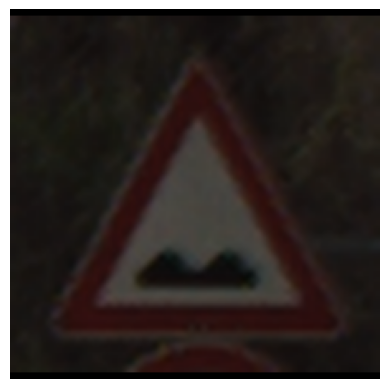

In [ ]:
# simply pick a class
random_class_label = random.randint(0, 42)
random_class = f'{random_class_label:02d}'

test_class_path = os.path.join(dataset_path, "new_test", random_class)
test_class_images = os.listdir(test_class_path)

# simply pick an image
num_images = len(test_class_images)
random_image = random.randint(0, num_images)
test_image_file = test_class_images[random_image]

test_image_path = os.path.join(test_class_path, test_image_file)

# read the image
test_image = img.imread(test_image_path)
# display the image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [ ]:
# load image into tensor
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)])

test_image = Image.open(test_image_path)
test_image = transform_test(test_image).unsqueeze(0)

import torchvision.models as models
# Load pretrained RestNet-50 model
resnet_model = models.resnet50(pretrained=True)
# Remove the final classification layer
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))
# Set model in evaluation mode
resnet_model.eval()

# pass image into ResNet
with torch.no_grad():
    test_feature = resnet_model(test_image)
test_feature = test_feature.squeeze().unsqueeze(0)

# predict label of image
onehot_prediction = best_model(test_feature)
onehot_prediction = onehot_prediction.squeeze()

# get the predicted class
class_prediction = onehot_prediction.argmax()
class_prediction = class_prediction.item()
class_prediction = idx_to_class[class_prediction]

# compare predicted class and actual class
print(f"predicted class = {class_prediction} | actual class = {random_class_label}")
if class_prediction == random_class_label:
    print("Yes! The prediction of our model is correct.")
else:
    print("No! The prediction of our model is wrong.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


predicted class = 22 | actual class = 22
Yes! The prediction of our model is correct.


# Confusion Matrix

In [ ]:
def get_labels_and_predictions(model, loader, limit=False):
  labels_list = []
  predictions_list = []
  for data in loader:
      inputs, labels = data
      predictions = model(inputs)
      labels_list += labels.clone().detach().numpy().flatten().tolist()
      predictions_list += np.argmax(predictions.clone().detach().numpy(), axis=1).tolist()
      if limit:
        break

  # map labels and predictions to classes
  class_labels_list = [idx_to_class[idx] for idx in labels_list]
  class_predictions_list = [idx_to_class[idx] for idx in predictions_list]

  return class_labels_list, class_predictions_list

In [ ]:
true, pred = get_labels_and_predictions(best_model, dataloader_combined_test)

Confusion Matrix:
[[27 19  7 ...  0  0  0]
 [ 1 59  3 ...  0  0  0]
 [ 0  5 59 ...  0  0  0]
 ...
 [ 0  0  0 ... 62  0  0]
 [ 0  0  0 ...  1 30 21]
 [ 0  0  0 ...  1  3 55]]


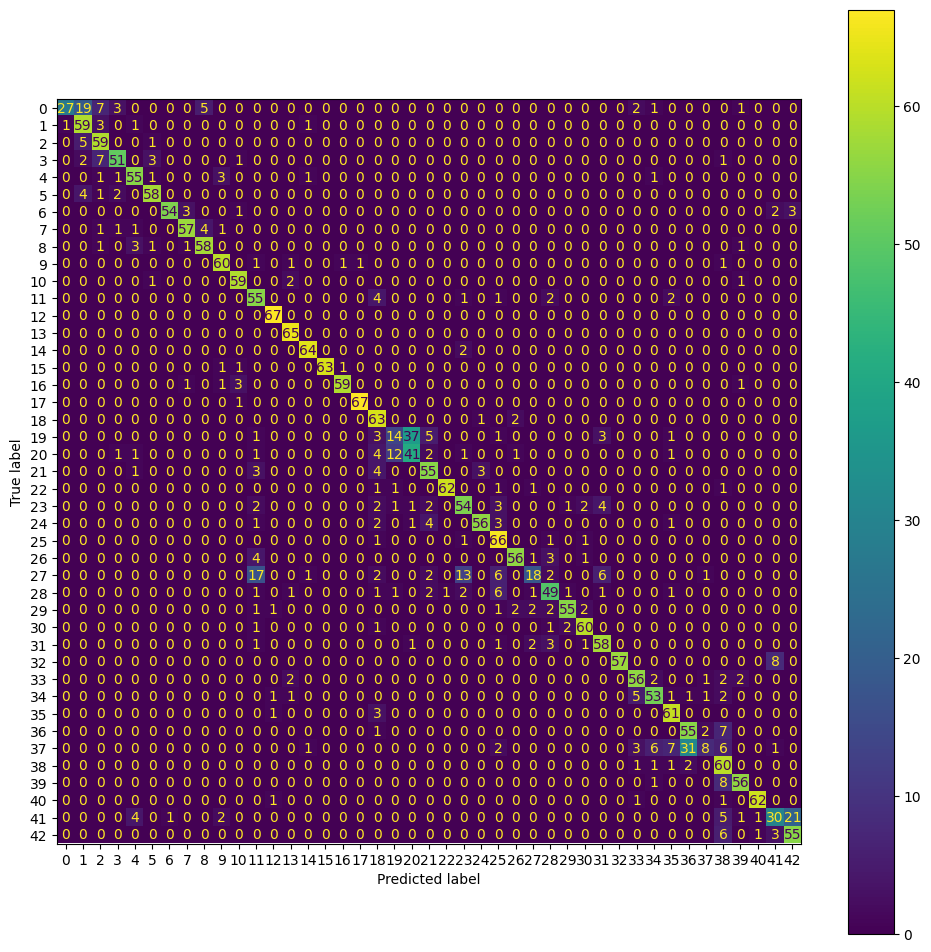

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(12,12))
ax = plt.gca()
disp.plot(ax=ax)
plt.show()